In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['slurm', 'combine_feature_info.txt', 'train_10000_randomSample.csv', 'mnt', 'combine_feature_60m_data.pkl', 'small_sample_for_param_tuning.pkl', '22_feature_bot60m_data.pkl', 'test.csv', 'train.csv', 'train.csv.zip', 'dat_info', '22_feature.pkl']


**Load training data and see what's inside.**

In [9]:
train_df = pd.read_csv('./input/train.csv',nrows=10000)
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
ip                 10000 non-null int64
app                10000 non-null int64
device             10000 non-null int64
os                 10000 non-null int64
channel            10000 non-null int64
click_time         10000 non-null object
attributed_time    23 non-null object
is_attributed      10000 non-null int64
dtypes: int64(6), object(2)
memory usage: 1.5 MB


In [10]:
test_df = pd.read_csv('./input/test.csv',nrows=10000)
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
click_id      10000 non-null int64
ip            10000 non-null int64
app           10000 non-null int64
device        10000 non-null int64
os            10000 non-null int64
channel       10000 non-null int64
click_time    10000 non-null object
dtypes: int64(6), object(1)
memory usage: 1.2 MB


In [11]:
test_df['click_time'] = pd.to_datetime(test_df['click_time'])
test_df['day'] = test_df['click_time'].dt.day
test_df['day'].value_counts()

10    10000
Name: day, dtype: int64

* We have 6 parameters types as int64 and 2  parameters types as object in training data, and 6 parameters types as int64 and 1  parameters types as object in testing data.
* The parameter, attributed_time, is not in the testing data, so let's drop it to save memory.
* ** Because we have only one day of test data, I using chunk to get one day of training data.**

In [12]:
del train_df
del test_df
df = pd.read_csv('./input/train.csv', iterator=True, chunksize=10000,nrows= 3700000, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
train_df = pd.concat([chunk[chunk['click_time'].str.contains("2017-11-06")] for chunk in df])
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3700000 entries, 0 to 3699999
Data columns (total 7 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
click_time       object
is_attributed    int64
dtypes: int64(6), object(1)
memory usage: 465.8 MB


In [13]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


* Now, let's take a look at the distribution of target (is_attributed).

0    0.998276
1    0.001724
Name: is_attributed, dtype: float64


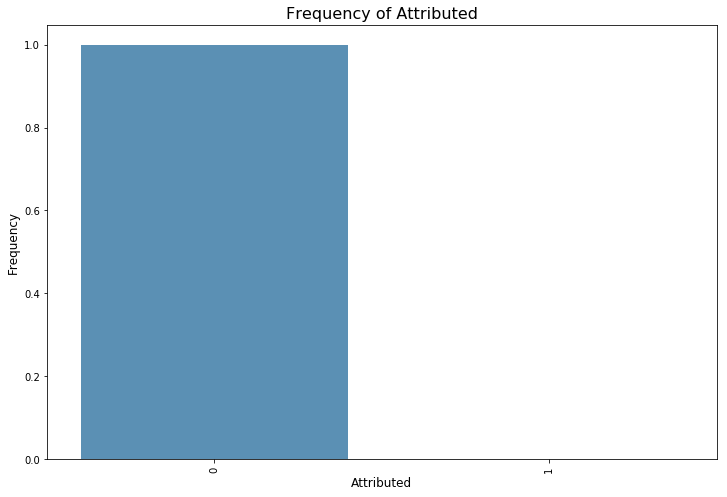

In [14]:
group_df = train_df.is_attributed.value_counts().reset_index()
k = group_df['is_attributed'].sum()
plt.figure(figsize = (12,8))
sns.barplot(group_df['index'], (group_df.is_attributed/k), alpha=0.8, color=color[0])
print((group_df.is_attributed/k))
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Attributed', fontsize = 12)
plt.title('Frequency of Attributed', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

count    3.700000e+06
mean     8.744684e+04
std      5.567258e+04
min      9.000000e+00
25%      4.257700e+04
50%      8.205400e+04
75%      1.206730e+05
max      2.127740e+05
Name: ip, dtype: float64


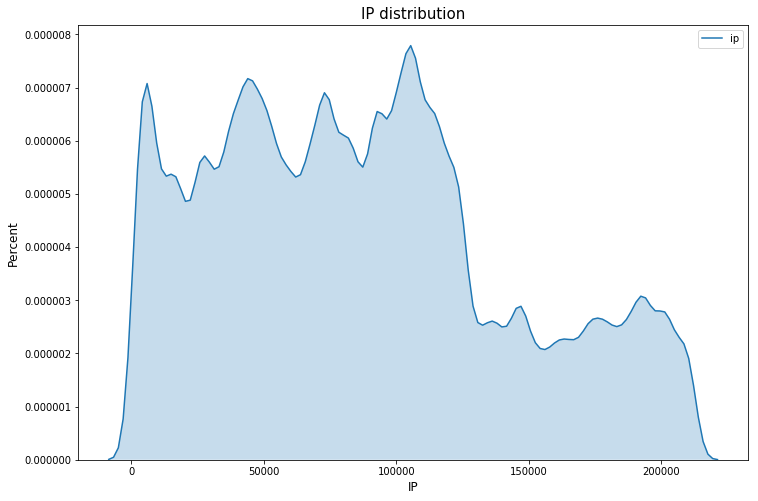

In [15]:
print(train_df.ip.describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(train_df.ip, shade=True)
plt.title('IP distribution', fontsize = 15)
plt.xlabel('IP', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

* **The distribution of IP data is average.**
* **After the int64 type parameters have been processed, we need to process the object type parameters.**

count    3.700000e+06
mean     1.249539e+01
std      1.554920e+01
min      0.000000e+00
25%      3.000000e+00
50%      1.200000e+01
75%      1.500000e+01
max      6.750000e+02
Name: app, dtype: float64


/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


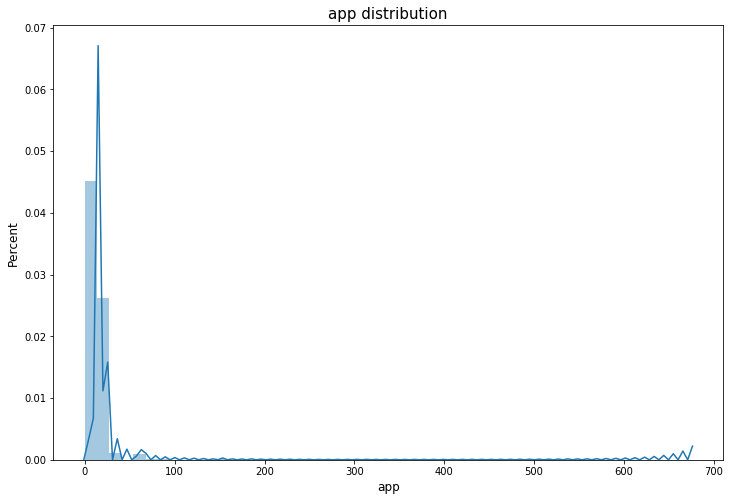

In [22]:
print(train_df.app.describe())
plt.figure(figsize=(12, 8))
sns.distplot(train_df.app)
plt.title('app distribution', fontsize = 15)
plt.xlabel('app', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

count    3.700000e+06
mean     2.822693e+01
std      2.848081e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.537000e+03
Name: device, dtype: float64


/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


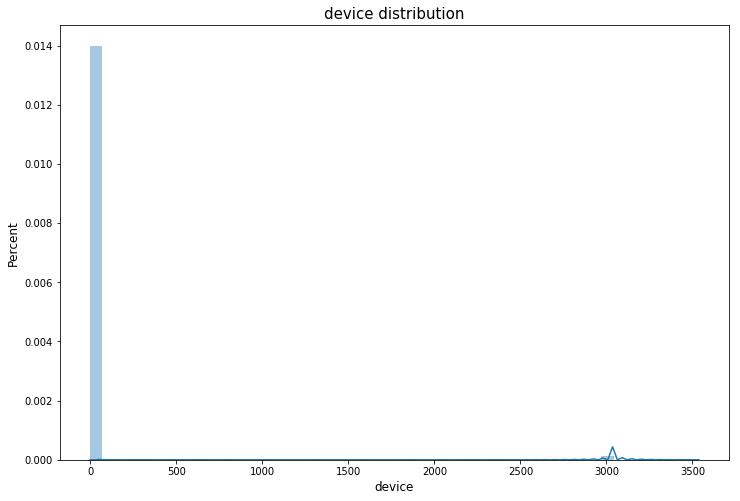

In [21]:
print(train_df.device.describe())
plt.figure(figsize=(12, 8))
sns.distplot(train_df.device)
plt.title('device distribution', fontsize = 15)
plt.xlabel('device', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

count    3.700000e+06
mean     2.484644e+02
std      1.260641e+02
min      0.000000e+00
25%      1.340000e+02
50%      2.430000e+02
75%      3.340000e+02
max      4.980000e+02
Name: channel, dtype: float64


/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


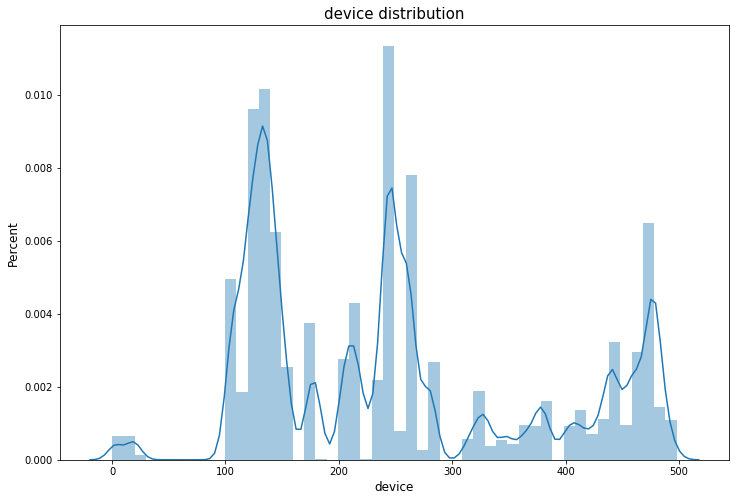

In [20]:
print(train_df.channel.describe())
plt.figure(figsize=(12, 8))
sns.distplot(train_df.channel)
plt.title('device distribution', fontsize = 15)
plt.xlabel('device', fontsize = 12)
plt.ylabel('Percent', fontsize = 12)
plt.show()

In [23]:
train_df['click_time'] = pd.to_datetime(train_df['click_time'])
train_df['hour'] = train_df['click_time'].dt.hour
train_df['minute'] = train_df['click_time'].dt.minute
train_df['second'] = train_df['click_time'].dt.second
train_df=train_df.drop(['click_time'], axis =1)

In [24]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3700000 entries, 0 to 3699999
Data columns (total 9 columns):
ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
hour             int64
minute           int64
second           int64
dtypes: int64(9)
memory usage: 282.3 MB


In [25]:
import gc
del df
gc.collect()

10171

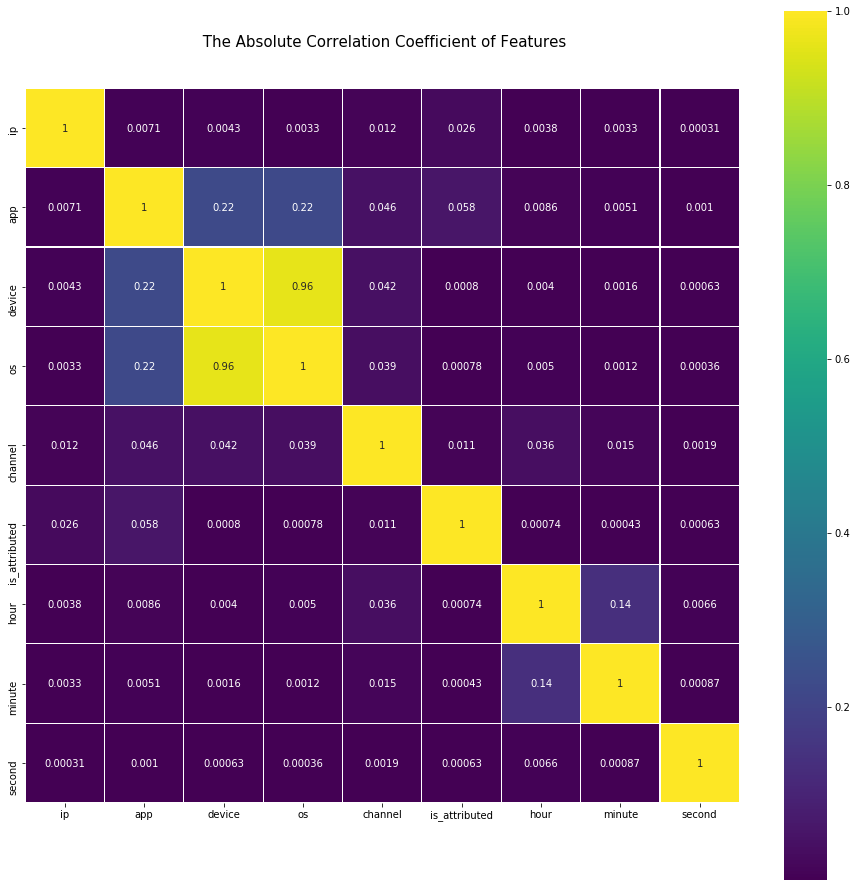

In [26]:
colormap = plt.cm.viridis
plt.figure(figsize=(16,16))
plt.title(' The Absolute Correlation Coefficient of Features', y=1.05, size=15)
sns.heatmap(abs(train_df.astype(float).corr()),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, )
plt.show()

* **From the picture.**
*  **We can know more important influence on is_attributed parameter is weekday, hour, ip, and app parameter.**
* **Thanks for Bryan Arnold, perhaps using the correlation coefficient is not the best way to express the method of targeting non-continuous data.**

**Let's group by some parameters**

In [27]:
#The frequency of each parameter (hours)
def group_by(lis_p, select_p, data, Agg=''):
    print('group by...')
    newname = '{}'.format('_'.join(lis_p))
    all_p = lis_p[:]
    all_p.append(select_p)
    if Agg=='':
        gp = data[all_p].groupby(by=lis_p)
        gp = gp[select_p].count().reset_index().rename(index=str, columns={select_p: newname})
    else:
        gp = data[all_p].groupby(by=lis_p).agg(Agg)
        gp = gp[select_p].reset_index().rename(index=str, columns={select_p: newname})
    print('merge...')
    data = data.merge(gp, on=lis_p, how='left')
    return data, newname
#The frequency of each parameter with IP (hours)
train_df, tmp1 = group_by(['ip', 'hour'], 'channel', train_df, 'count')
train_df, tmp2 = group_by(['ip', 'hour', 'device'], 'channel', train_df, 'count')
train_df, tmp3 = group_by(['ip', 'hour', 'app'], 'channel', train_df, 'count')                  
train_df, tmp4 = group_by(['ip', 'hour', 'channel'], 'os', train_df, 'count')
train_df, tmp5 = group_by(['ip', 'hour', 'os'], 'channel', train_df, 'count')
parameter_with_IP = [tmp1,tmp2,tmp3,tmp4,tmp5]
del tmp1
del tmp2
del tmp3
del tmp4
del tmp5
#train_df = train_df.drop( ['ip'], axis=1)
gc.collect()


group by...
merge...
group by...
merge...
group by...
merge...
group by...
merge...
group by...
merge...


6592

In [28]:
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame|
    """

    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])
    data['abs_WoE'] = abs(data['WoE'])
    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())
    return data
def loop_iv(lis_val, train_df):
    dic_val = {}
    for i in lis_val:
        data = calc_iv(train_df, i, 'is_attributed')
        dic_val[i] = data
        print("Done {0}".format(i))
    return dic_val

In [29]:
lis=list(train_df.columns)
lis.remove('is_attributed')
lis.remove('ip')
lis.remove('hour')
lis.remove('minute')
lis.remove('second')
dic=loop_iv(lis, train_df)

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Done app
Done device
Done os
Done channel
Done ip_hour
Done ip_hour_device
Done ip_hour_app
Done ip_hour_channel
Done ip_hour_os


In [30]:
dic_num = {}
for i in lis:
    nr_woe = dic[i]['WoE'].argmax()
    nr_iv = dic[i]['IV'].argmax()
    dic_num[i] = [nr_woe, nr_iv]

/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until
/apps/software/standard/core/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


The sum of IV parameter in app : 5.217628077433765
The sum of IV parameter in device : 1.466152696885912
The sum of IV parameter in os : 1.524469301472115
The sum of IV parameter in channel : 4.952889895584937
The sum of IV parameter in ip_hour : 1.848030066900213
The sum of IV parameter in ip_hour_device : 2.2692335279085447
The sum of IV parameter in ip_hour_app : 2.0031607550288593
The sum of IV parameter in ip_hour_channel : 1.199652976057659
The sum of IV parameter in ip_hour_os : 1.9642959713230108


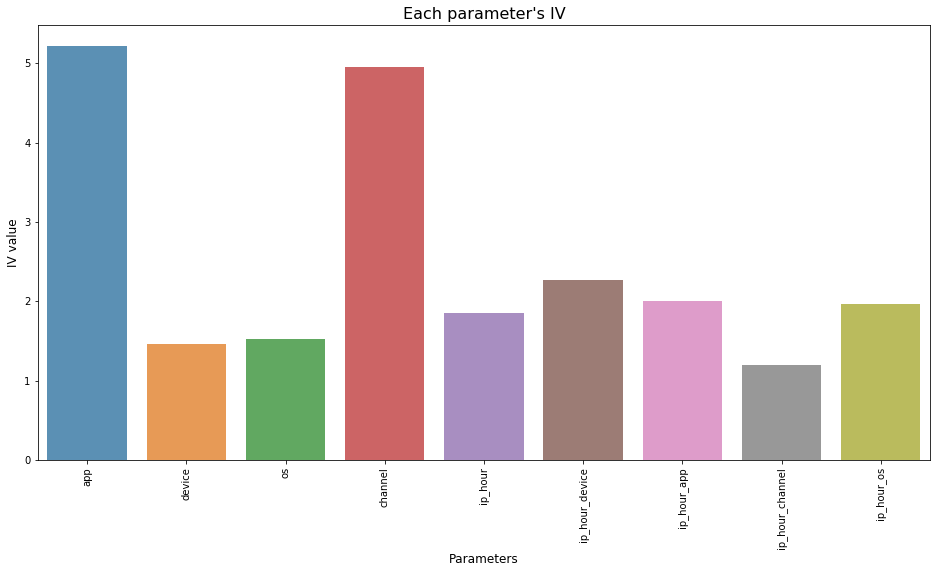

In [31]:
sum_iV={}
for i in lis:
    sum_num = dic[i]['IV'].sum()
    sum_iV[i] = sum_num
    print("The sum of IV parameter in {0} : {1}".format(i, sum_num))
plt.figure(figsize = (16,8))
m_colors=[]
k_num=0
for num in range(len(lis)):
    if (num//len(color))>k_num:
        k_num+=1
    t = num - k_num*len(color)
    m_colors.append(color[t])
sns.barplot(list(sum_iV.keys()), list(sum_iV.values()), alpha=0.8, palette = m_colors)
plt.ylabel('IV value', fontsize = 12)
plt.xlabel('Parameters', fontsize = 12)
plt.title("Each parameter's IV", fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()